In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from scipy.optimize import curve_fit

In [6]:
obs = get_pkg_data_filename("Data\GD71_onoff_IFU_FLUX_IFU_MERGE3D_DATA_OBJ_VIS.fits")
hdul = fits.open("Data\GD71_onoff_IFU_FLUX_IFU_MERGE3D_DATA_OBJ_VIS.fits")
header = hdul[0].header
N = header["NAXIS3"]
pix_x = header["NAXIS1"]
pix_y = header["NAXIS2"]
pix_x_inicial = header["NAXIS1"]
pix_y_inicial = header["NAXIS2"]
dx = np.abs(header["CDELT1"]) * 60 * 60
dy = np.abs(header["CDELT2"]) * 60 * 60
wave_NIR = np.zeros(N)
for i in range(N):
    wave_NIR[i] = (i+header["CRPIX3"])*header["CDELT3"] + header["CRVAL3"]
#obtain the data and wavelength
data_nir = fits.getdata(obs, ext=0)[:, :, :]

centro_x = np.ones(len(wave_NIR))*1

In [7]:
centro_y = np.zeros(len(wave_NIR))
for l in range(len(wave_NIR)):
    suma_y = 0
    mass_center_y = 0

    for j in range(pix_y):
        mass_center_y += (j*np.sum(data_nir[l, j, :]))
        suma_y += np.sum(data_nir[l, j, :])

    centro_y[l] = mass_center_y / suma_y

[11.49618884 11.49561114 11.49503347 ...  7.12266322  7.1228812
  7.12309921]


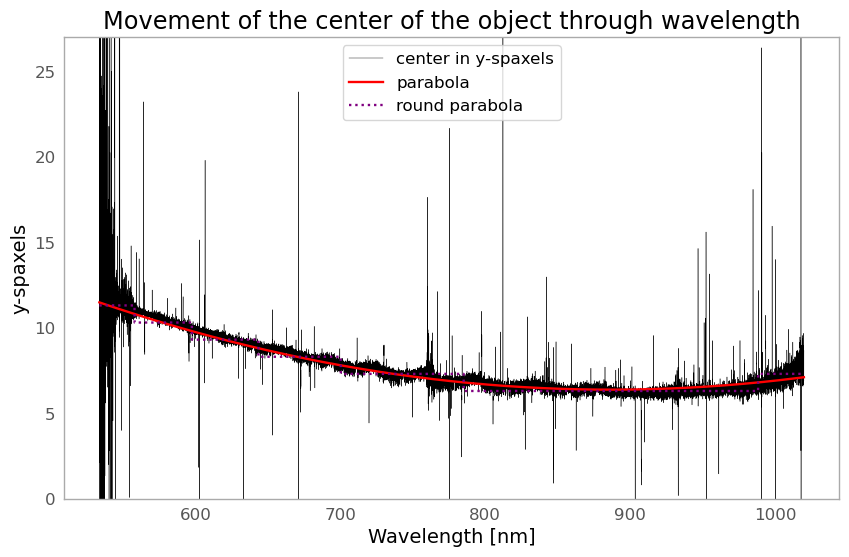

In [8]:
from scipy.optimize import curve_fit

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Define the parabola function
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

# Fit a parabola to the data using curve_fit()
popt, pcov = curve_fit(parabola, wave_NIR[1000:], centro_y[1000:] - centro_y[0])

# Plot the data and the parabola

axes.set_title("Movement of the center of the object through wavelength")
axes.plot(wave_NIR, centro_y,  linewidth=0.3, c="k", alpha=1, label='center in y-spaxels')
axes.plot(wave_NIR, centro_y[0] + parabola(wave_NIR, *popt), c="red", label='parabola')
axes.plot(wave_NIR, centro_y[0] + np.round(parabola(wave_NIR, *popt)), linestyle=":", c="purple", label='round parabola', zorder=10)
axes.set_ylim(0, pix_y + 1)
axes.set_xlabel("Wavelength [nm]", fontsize=14)
axes.set_ylabel("y-spaxels", fontsize=14)
axes.grid(False)
axes.legend()

mov_centro = np.round(centro_y[0] + parabola(wave_NIR, *popt))
mov_centro_float = centro_y[0] + parabola(wave_NIR, *popt)
print(centro_y[0] + parabola(wave_NIR, *popt))

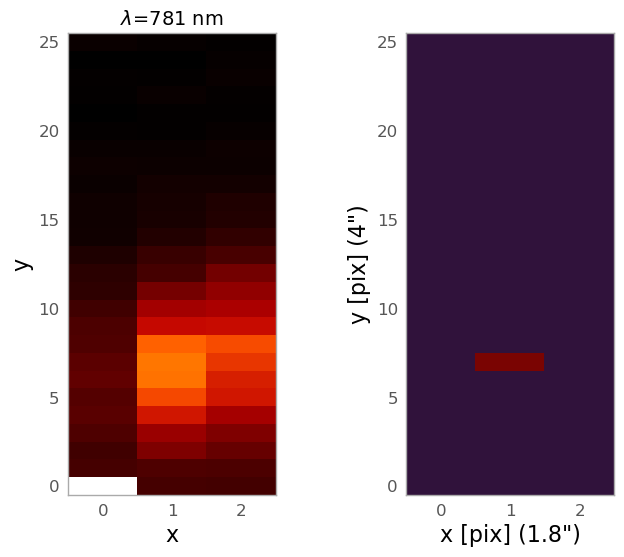

In [9]:
import matplotlib.animation as animation
import matplotlib as mpl

fig, axes = plt.subplots(1, 2, figsize=(8, 6))
T = np.arange(1, 125)  # vector temporal


def n(t):

    t = t*100
    axes[0].imshow(data_nir[t, :, :], aspect=0.25641,  origin="lower")
    axes[0].set_title("$\lambda$=" + str(int(wave_NIR[t])) + " nm", fontsize=14)
    axes[0].set_ylabel("y", fontsize=16)
    axes[0].set_xlabel("x", fontsize=16)
    axes[0].grid(False)

    planet_center = np.zeros((pix_y, pix_x))
    for i in range(pix_x):
        for j in range(pix_y):
            if (i == centro_x[t]) and  (j == mov_centro[t]):
                planet_center[j, i] = 1

    axes[1].imshow(planet_center, aspect=0.25641, origin="lower", cmap=mpl.colormaps["turbo"])
    axes[1].set_ylabel('y [pix] (4")', fontsize=16)
    axes[1].set_xlabel('x [pix] (1.8")', fontsize=16)
    axes[1].grid(False)


ani = animation.FuncAnimation(fig, n, T, interval= 10)
writergif = animation.PillowWriter(fps=30)
ani.save('..\Gifs\centerVIS_off1.gif', writer=writergif)
plt.show()

In [10]:
diferencia_centro = int(np.max(mov_centro) - np.min(mov_centro))
largo_y = int(pix_y + diferencia_centro)
diff_vec = mov_centro - mov_centro[0] 
diff_vec_float = mov_centro_float - mov_centro[0]

In [11]:
pix_to_another = mov_centro_float - np.round(mov_centro_float)

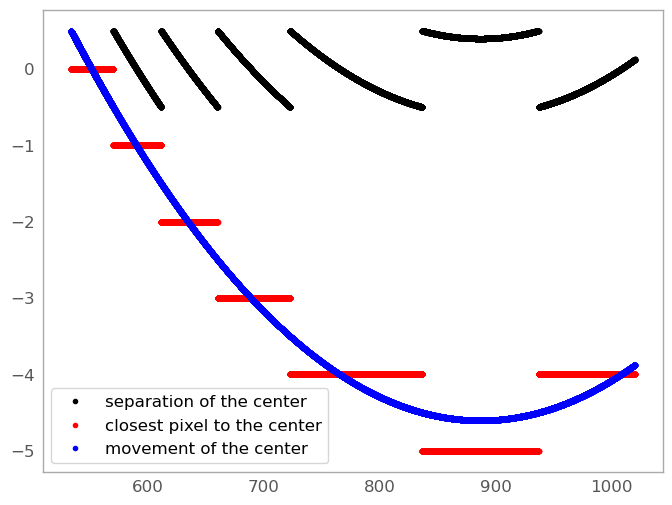

In [12]:
plt.plot(wave_NIR, pix_to_another, ".", c="k", label="separation of the center")
plt.plot(wave_NIR, diff_vec, ".", c="red", label="closest pixel to the center")
plt.plot(wave_NIR, diff_vec + pix_to_another, ".", c="blue", label="movement of the center")
plt.legend()
plt.grid(False)

In [13]:
medianas_ = np.zeros((pix_y, pix_x))

for i in range(pix_x):
    for j in range(pix_y):
        medianas_[j, i] = np.nanpercentile(data_nir[:, j, i], 50)

In [14]:
data_norm = np.zeros((len(wave_NIR), largo_y, pix_x))
for l in range(len(wave_NIR)):
    for i in range(pix_x):
        for j in range(pix_y):
            if (pix_to_another[l]) < 0:
                if j == 0:
                    data_norm[l, int(j - diff_vec[l]), i] = data_nir[l, j, i] * (1 + (pix_to_another[l]))
                else:
                    ponderado = medianas_[j, i] / medianas_[j-1, i]
                    data_norm[l, int(j - diff_vec[l]), i] = data_nir[l, j, i] * (1 + (pix_to_another[l])) + data_nir[l, j-1, i] * (pix_to_another[l]) * (-1) * ponderado 
            if (pix_to_another[l]) >= 0:
                if j == pix_y-1:
                    data_norm[l, int(j - diff_vec[l]), i] = data_nir[l, j, i] * (1 - (pix_to_another[l]))
                else:
                    ponderado = medianas_[j, i] / medianas_[j+1, i]
                    data_norm[l, int(j - diff_vec[l]), i] = data_nir[l, j, i] * (1 - (pix_to_another[l])) + data_nir[l, j+1, i] * (pix_to_another[l]) / ponderado

            if largo_y > pix_y:
                for d in range(largo_y - pix_y):
                    data_norm[l, int((largo_y - diff_vec[l] - d -1)%largo_y), i] = None

In [15]:
data_norm_ = np.zeros((len(wave_NIR), largo_y, pix_x))
for l in range(len(wave_NIR)):
    for i in range(pix_x):
        for j in range(pix_y):
            data_norm_[l, int(j - diff_vec[l]), i] = data_nir[l, j, i] 

            if largo_y > pix_y:
                for d in range(largo_y - pix_y):
                    data_norm_[l, int((largo_y - diff_vec[l] - d -1)%largo_y), i] = None

In [16]:
cut_offset = data_norm[:, diferencia_centro:int(largo_y-diferencia_centro), :].copy()
cut_offset_ = data_norm_[:, diferencia_centro:int(largo_y-diferencia_centro), :].copy()

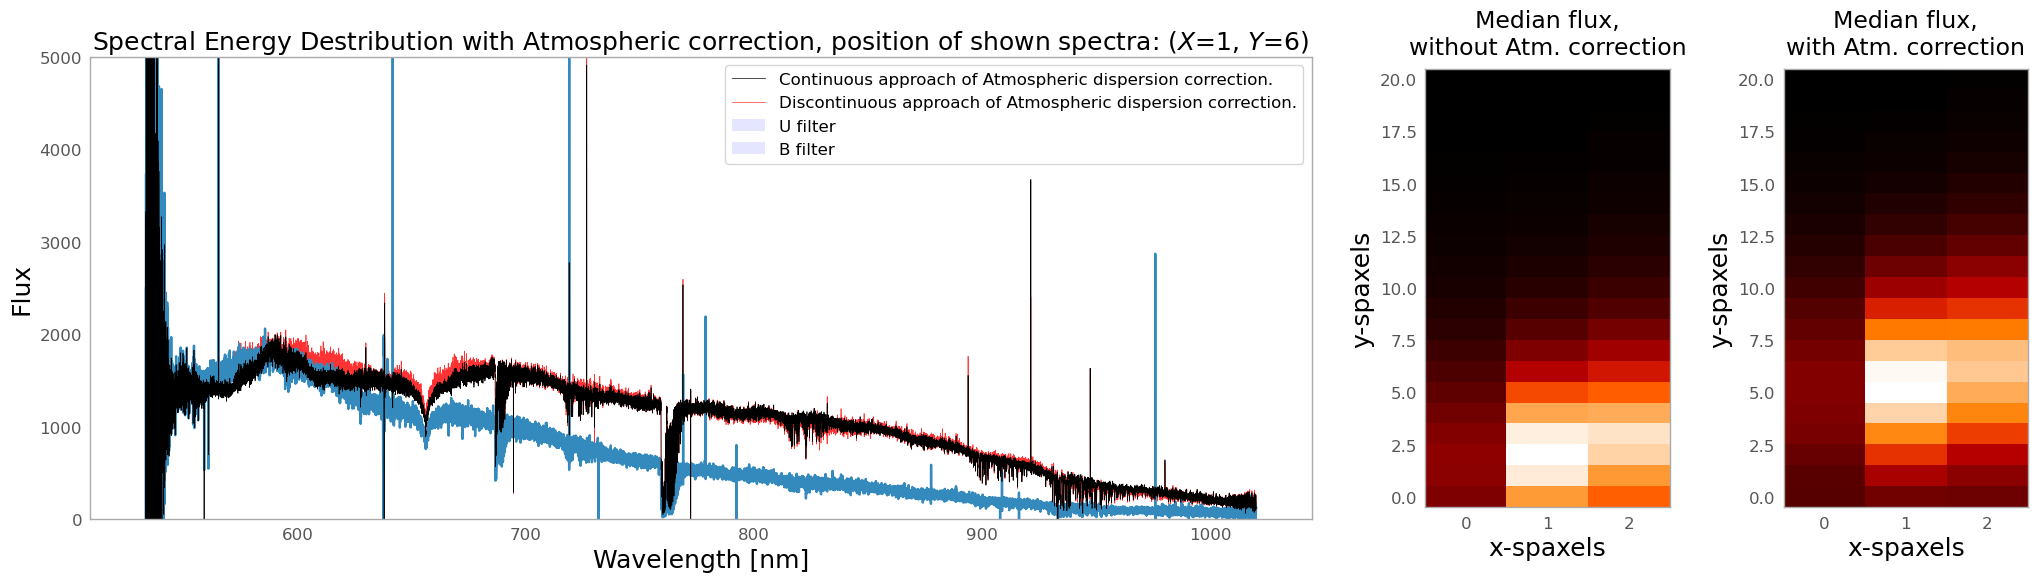

In [17]:
def closest(x, arr):
    difference_array = np.absolute(arr-x)
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index

X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 6 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

ylim = 5000

# !!! Porque NIR tiene solo 20 pixeles? !!!

fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [5, 1, 1]}, figsize=(25, 6))


#axes[0].plot(wave_NIR, data_nir[:, Y, X], c="blue", linewidth=.5, alpha=1, label="Continuous approach of Atmospheric dispersion correction.")
#axes[0].plot(wave_NIR, data_nir[:, 7, X], c="green", linewidth=.5, alpha=0.8, label="Discontinuous approach of Atmospheric dispersion correction.", zorder=-10)
axes[0].set_title("Spectral Energy Destribution with Atmospheric correction, position of shown spectra: ($X$=" + str(X) + ", $Y$=" + str(Y) + ")", fontsize=18)
axes[0].plot(wave_NIR, data_nir[:, Y + diferencia_centro, X])
axes[0].plot(wave_NIR, cut_offset[:, Y, X], c="k", linewidth=.5, alpha=1, label="Continuous approach of Atmospheric dispersion correction.")
axes[0].plot(wave_NIR, cut_offset_[:, Y, X], c="red", linewidth=.5, alpha=0.8, label="Discontinuous approach of Atmospheric dispersion correction.", zorder=-10)
axes[0].set_ylabel("Flux", fontsize=18)
axes[0].set_xlabel("Wavelength [nm]", fontsize=18)

axes[0].set_ylim(-1, ylim)

axes[0].grid(False)


a = int(closest(320, wave_NIR))
b = int(closest(400, wave_NIR))
axes[0].fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="U filter")

a = int(closest(400, wave_NIR))
b = int(closest(500, wave_NIR))
axes[0].fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="B filter")



axes[0].legend()
medianas = np.zeros((largo_y - 2 * diferencia_centro, pix_x))

for i in range(pix_x):
    for j in range(diferencia_centro, largo_y - diferencia_centro):
        medianas[j - diferencia_centro, i] = np.nanpercentile(data_nir[:, j, i], 50)

axes[1].imshow(medianas, aspect=0.25641,  origin="lower")
axes[1].set_ylabel("y-spaxels", fontsize=18)
axes[1].set_xlabel("x-spaxels", fontsize=18)
axes[1].grid(False)

medianas = np.zeros((largo_y - 2 * diferencia_centro, pix_x))

for i in range(pix_x):
    for j in range(largo_y - 2*diferencia_centro):
        medianas[j, i] = np.nanpercentile(cut_offset[:, j, i], 50)

axes[2].imshow(medianas, aspect=0.25641,  origin="lower")
axes[2].text(0.5, 1.08, "Median flux,\nwith Atm. correction", ha='center', va='center', transform=axes[2].transAxes, fontsize=17, multialignment='center')
axes[1].text(0.5, 1.08, "Median flux,\nwithout Atm. correction", ha='center', va='center', transform=axes[1].transAxes, fontsize=17, multialignment='center')
axes[2].set_ylabel("y-spaxels", fontsize=18)
axes[2].set_xlabel("x-spaxels", fontsize=18)
axes[2].grid(False)

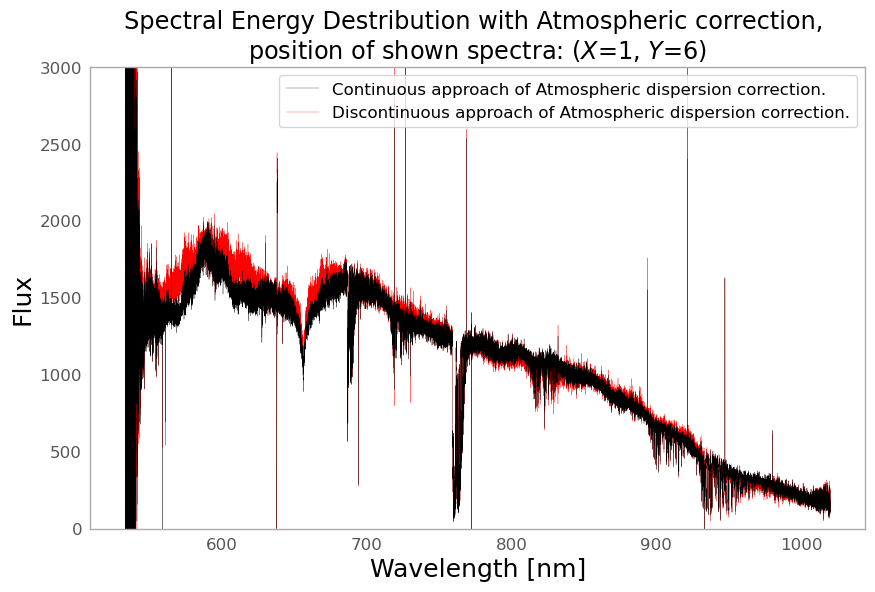

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 6 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

ylim = 3000

axes.set_title("Spectral Energy Destribution with Atmospheric correction, \nposition of shown spectra: ($X$=" + str(X) + ", $Y$=" + str(Y) + ")")
axes.plot(wave_NIR, cut_offset[:, Y, X], c="k", linewidth=.2, alpha=1, label="Continuous approach of Atmospheric dispersion correction.")
axes.plot(wave_NIR, cut_offset_[:, Y, X], c="red", linewidth=.2, alpha=1, label="Discontinuous approach of Atmospheric dispersion correction.", zorder=-10)
axes.set_ylabel("Flux", fontsize=18)
axes.set_xlabel("Wavelength [nm]", fontsize=18)

axes.set_ylim(-1, ylim)
#axes.set_xlim(295, 555)

axes.grid(False)


a = int(closest(320, wave_NIR))
b = int(closest(400, wave_NIR))
#axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="U filter")

a = int(closest(400, wave_NIR))
b = int(closest(500, wave_NIR))
#axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="B filter")
axes.legend()



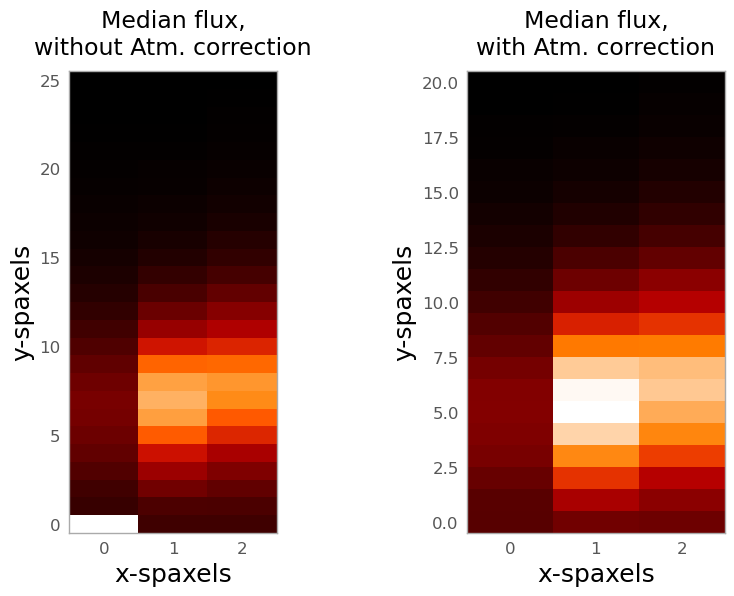

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

medianas = np.zeros((pix_y, pix_x))
for i in range(pix_x):
    for j in range(pix_y):
        medianas[j, i] = np.nanpercentile(data_nir[:, j, i], 50)

axes[0].imshow(medianas, aspect=0.25641,  origin="lower")
axes[0].set_ylabel("y-spaxels", fontsize=18)
axes[0].set_xlabel("x-spaxels", fontsize=18)
axes[0].grid(False)

medianas = np.zeros((largo_y - 2 * diferencia_centro, pix_x))

for i in range(pix_x):
    for j in range(largo_y - 2*diferencia_centro):
        medianas[j, i] = np.nanpercentile(cut_offset[:, j, i], 50)

axes[1].imshow(medianas, aspect=0.25641,  origin="lower")
axes[1].text(0.5, 1.08, "Median flux,\nwith Atm. correction", ha='center', va='center', transform=axes[1].transAxes, fontsize=17, multialignment='center')
axes[0].text(0.5, 1.08, "Median flux,\nwithout Atm. correction", ha='center', va='center', transform=axes[0].transAxes, fontsize=17, multialignment='center')
axes[1].set_ylabel("y-spaxels", fontsize=18)
axes[1].set_xlabel("x-spaxels", fontsize=18)
axes[1].grid(False)

In [20]:
pix_y = int(largo_y - 2*diferencia_centro)
max_lambda = 9500
min_lambda = 8300
centro = (mov_centro[0] - diferencia_centro, 1)

dx = 1.8 / (pix_x_inicial + 1)
dy = 4 / (pix_y_inicial + 1)

In [21]:
distance_matrix = np.zeros((pix_y, pix_x))

for i in range(pix_x):
    for j in range(pix_y):
        distance_matrix[j, i] = np.sqrt( (dy*(j-centro[0]))**2 + (dx*(i-centro[1]))**2)

max_distance = np.max(distance_matrix)
radius = np.linspace(0, max_distance, 100)

In [22]:
spiky_data = cut_offset.copy()

In [23]:
# Lets choose a window n


A = 5
ventana = 100
N = len(cut_offset) - ventana//2
medianas = np.zeros((pix_y, pix_x))
IQR = np.zeros(len(cut_offset))

for long_onda in range(ventana//2, N):
    for i in range(pix_x):
        for j in range(pix_y):
        
            medianas[j, i] = np.nanpercentile(cut_offset[long_onda-ventana//2:long_onda+ventana//2, j, i], 50)
    
    variable_y = (cut_offset[long_onda]/medianas).reshape(pix_x*pix_y)
    variable_x = distance_matrix.reshape(pix_x*pix_y)
    mediana = np.nanpercentile(variable_y, 50)
    desviacion = variable_y - mediana
    upper_limit = np.nanpercentile(desviacion, 75)
    lower_limit = np.nanpercentile(desviacion, 25)
    IQR[long_onda] = upper_limit - lower_limit
    desviacion = desviacion.reshape(pix_y, pix_x)
    for lambda_x in range(pix_x):
        for lambda_y in range(pix_y):
            if (desviacion[lambda_y, lambda_x] > A*upper_limit) or (desviacion[lambda_y, lambda_x] < A*lower_limit):
                cut_offset[long_onda, lambda_y, lambda_x] = medianas[lambda_y, lambda_x]


Text(0.5, 0, 'x-spaxels')

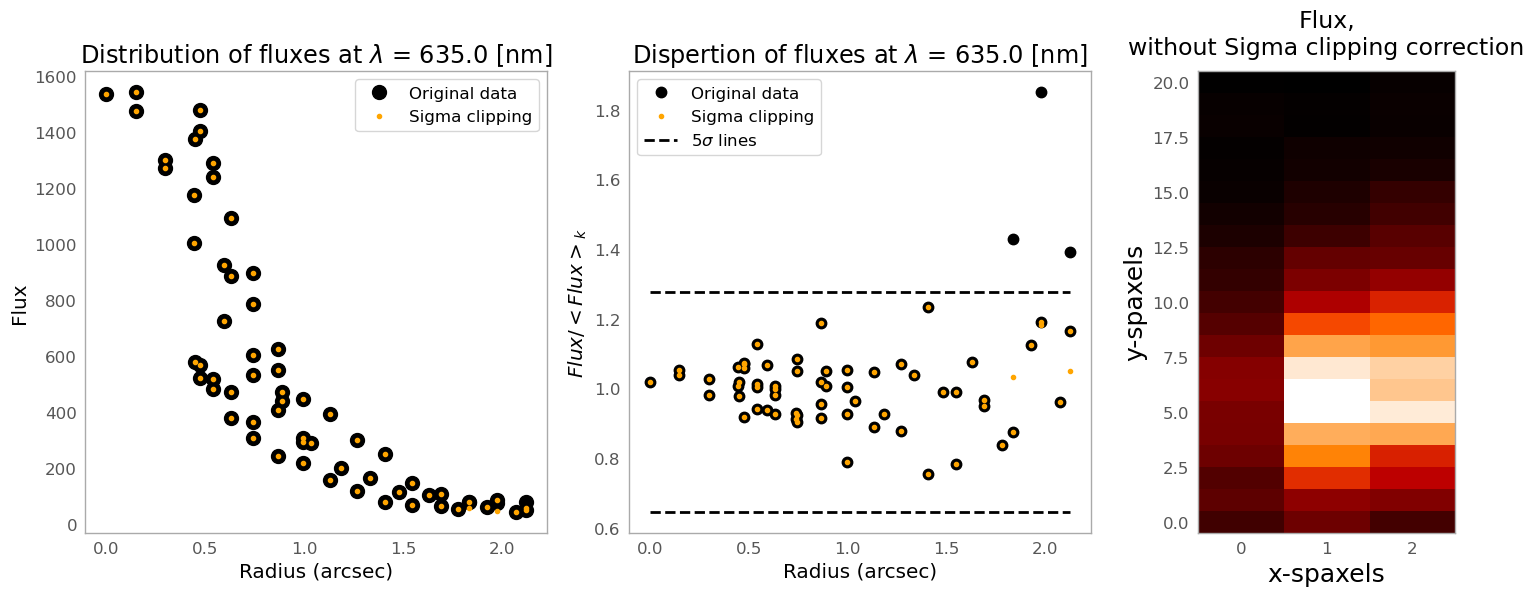

In [24]:
fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.5, 1.5, 1]}, figsize=(18, 6))

long_onda = 5045
axes[0].plot(distance_matrix.reshape(pix_x*pix_y), spiky_data[long_onda, :, :].reshape(pix_x*pix_y), ".", c="k", markersize=20, label="Original data")
axes[0].plot(distance_matrix.reshape(pix_x*pix_y), cut_offset[long_onda, :, :].reshape(pix_x*pix_y), ".", c="orange", label="Sigma clipping")
axes[0].set_title("Distribution of fluxes at $\lambda$ = " + str(np.round(wave_NIR[long_onda]))+ " [nm]")
axes[0].set_xlabel("Radius (arcsec)")
axes[0].set_ylabel("Flux")
axes[0].legend()
axes[0].grid(False)

ventana = 100
medianas = np.zeros((pix_y, pix_x))
for i in range(pix_x):
    for j in range(pix_y):
        
        medianas[j, i] = np.nanpercentile(spiky_data[long_onda-ventana//2:long_onda+ventana//2, j, i], 50)


mediana_ = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y), 50)
lower = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y) - mediana_, 25)
upper = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y) - mediana_, 75)

axes[1].plot(distance_matrix.reshape(pix_x*pix_y), (spiky_data[long_onda]/medianas).reshape(pix_x*pix_y), ".", c="k", markersize=15, label="Original data")
axes[1].plot(distance_matrix.reshape(pix_x*pix_y), (cut_offset[long_onda]/medianas).reshape(pix_x*pix_y), ".", c="orange", label="Sigma clipping")
axes[1].set_title("Dispertion of fluxes at $\lambda$ = " + str(np.round(wave_NIR[long_onda]))+ " [nm]")


axes[1].hlines(A*upper + mediana_, 0, np.max(distance_matrix.reshape(pix_x*pix_y)), linestyle="--", color="k", linewidth=2, label="$5 \sigma$ lines")
axes[1].hlines(A*lower + mediana_, 0, np.max(distance_matrix.reshape(pix_x*pix_y)), linestyle="--", color="k", linewidth=2)
axes[1].grid(False)
axes[1].legend()
axes[1].set_xlabel("Radius (arcsec)")
axes[1].set_ylabel("$Flux / <Flux>_k$")
#axes[1].set_ylim(0.1, 1.5)

axes[2].imshow(spiky_data[long_onda, :, :], aspect=0.25641,  origin="lower")
axes[2].grid(False)
axes[2].text(0.5, 1.08, "Flux,\nwithout Sigma clipping correction", ha='center', va='center', transform=axes[2].transAxes, fontsize=17, multialignment='center')
axes[2].set_ylabel("y-spaxels", fontsize=18)
axes[2].set_xlabel("x-spaxels", fontsize=18)


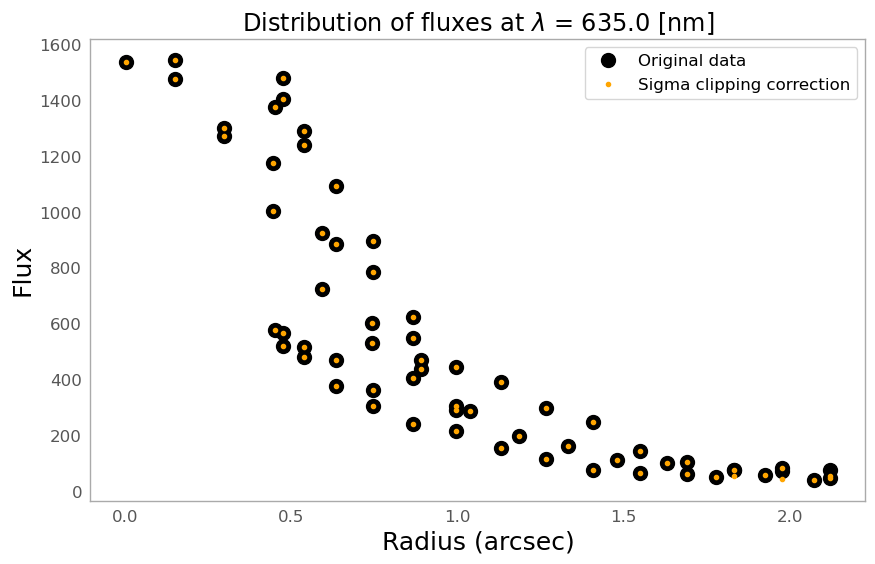

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(distance_matrix.reshape(pix_x*pix_y), spiky_data[long_onda, :, :].reshape(pix_x*pix_y), ".", c="k", markersize=20, label="Original data")
axes.plot(distance_matrix.reshape(pix_x*pix_y), cut_offset[long_onda, :, :].reshape(pix_x*pix_y), ".", c="orange", label="Sigma clipping correction")
axes.set_title("Distribution of fluxes at $\lambda$ = " + str(np.round(wave_NIR[long_onda]))+ " [nm]")
axes.set_xlabel("Radius (arcsec)", fontsize=18)
axes.set_ylabel("Flux", fontsize=18)
axes.legend()
axes.grid(False)

Text(0, 0.5, '$Flux / <Flux>_k$')

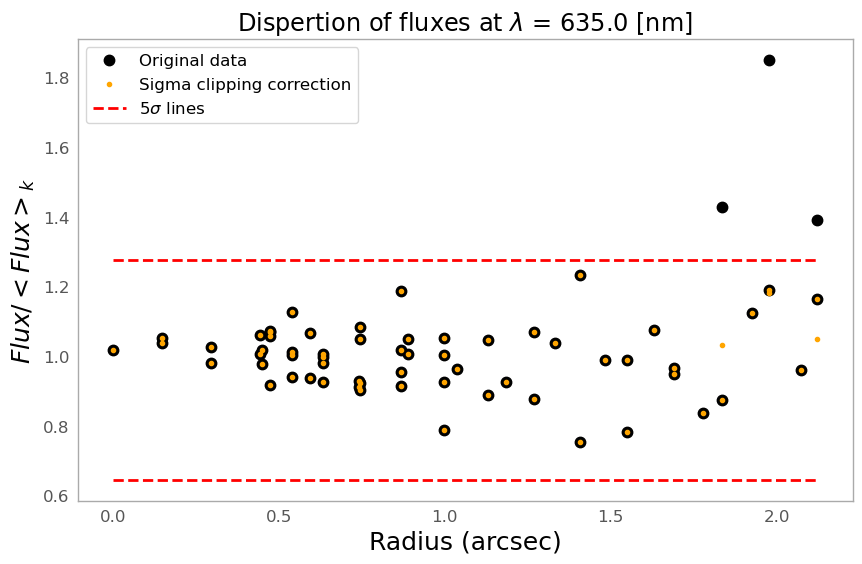

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ventana = 100
medianas = np.zeros((pix_y, pix_x))
for i in range(pix_x):
    for j in range(pix_y):
        
        medianas[j, i] = np.nanpercentile(spiky_data[long_onda-ventana//2:long_onda+ventana//2, j, i], 50)


mediana_ = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y), 50)
lower = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y) - mediana_, 25)
upper = np.nanpercentile((spiky_data[long_onda]/medianas).reshape(pix_x*pix_y) - mediana_, 75)

axes.plot(distance_matrix.reshape(pix_x*pix_y), (spiky_data[long_onda]/medianas).reshape(pix_x*pix_y), ".", c="k", markersize=15, label="Original data")
axes.plot(distance_matrix.reshape(pix_x*pix_y), (cut_offset[long_onda]/medianas).reshape(pix_x*pix_y), ".", c="orange", label="Sigma clipping correction")
axes.set_title("Dispertion of fluxes at $\lambda$ = " + str(np.round(wave_NIR[long_onda]))+ " [nm]")


axes.hlines(A*upper + mediana_, 0, np.max(distance_matrix.reshape(pix_x*pix_y)), linestyle="--", color="r", linewidth=2, label="$5 \sigma$ lines")
axes.hlines(A*lower + mediana_, 0, np.max(distance_matrix.reshape(pix_x*pix_y)), linestyle="--", color="r", linewidth=2)
axes.grid(False)
#axes.set_ylim(0.5, 1.5)
axes.legend()
axes.set_xlabel("Radius (arcsec)", fontsize=18)
axes.set_ylabel("$Flux / <Flux>_k$", fontsize=18)

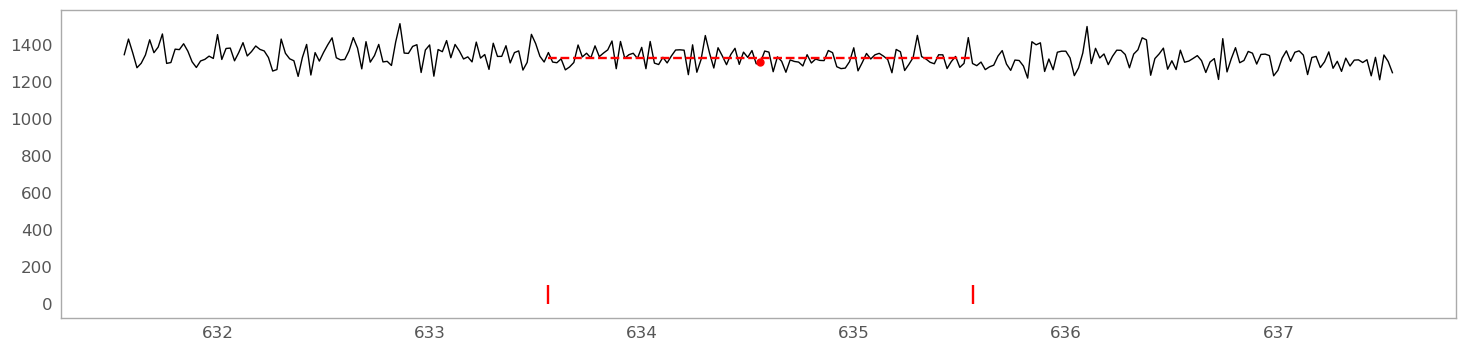

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(18, 4))
X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 4 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

axes.plot(wave_NIR[long_onda-ventana*3//2:long_onda+ventana*3//2], cut_offset[long_onda-ventana*3//2:long_onda+ventana*3//2, Y, X], c="k", linewidth=1, label="espectro")
axes.vlines(wave_NIR[long_onda-ventana//2], 0, 100, color="red")
axes.vlines(wave_NIR[long_onda+ventana//2], 0, 100, color="red")
axes.hlines(np.nanpercentile(cut_offset[long_onda-ventana*3//2:long_onda+ventana*3//2, Y, X], 50), wave_NIR[long_onda-ventana//2], wave_NIR[long_onda+ventana//2], color="red", linestyles="--")
axes.plot(wave_NIR[long_onda], cut_offset[long_onda, Y, X], ".", markersize=10, color="r")
axes.grid(False)

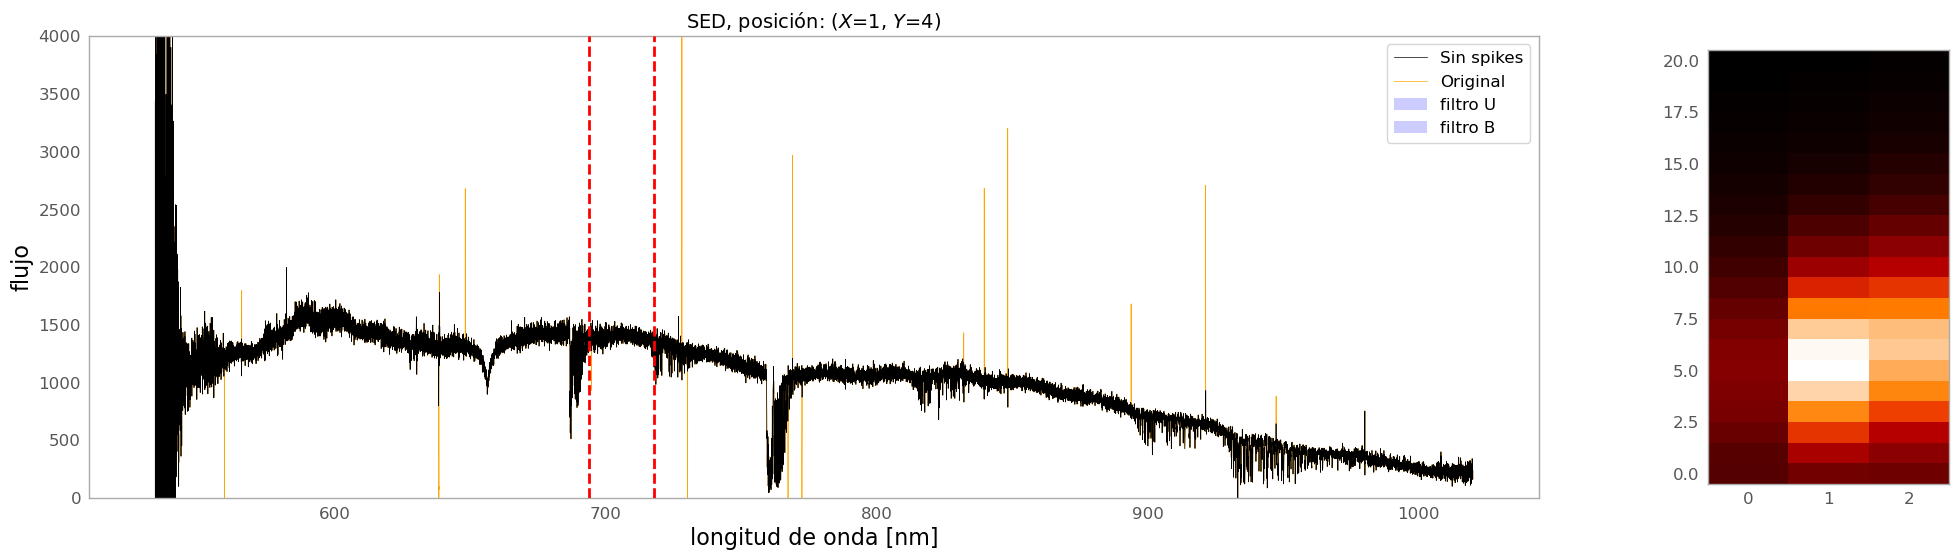

In [28]:
X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 4 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

ylim = 4000

# !!! Porque NIR tiene solo 20 pixeles? !!!

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]}, figsize=(24, 6))



axes[0].set_title("SED, posición: ($X$=" + str(X) + ", $Y$=" + str(Y) + ")", fontsize=14)
axes[0].plot(wave_NIR, cut_offset[:, Y, X], c="k", linewidth=.5, label="Sin spikes")
axes[0].plot(wave_NIR, spiky_data[:, Y, X], c="orange", linewidth=.5, label="Original", zorder=-1)
axes[0].set_ylabel("flujo", fontsize=16)
axes[0].set_xlabel("longitud de onda [nm]", fontsize=16)
#axes.set_xscale("log")
axes[0].set_ylim(-1, ylim)
#axes[0].hlines(0, 1000, 2500 , color="red", zorder=10)

axes[0].vlines(wave_NIR[8000], 0, ylim, color="red", linewidth=2, linestyle="--", zorder=11)
axes[0].vlines(wave_NIR[9200], 0, ylim, color="red", linewidth=2, linestyle="--", zorder=11)


axes[0].grid(False)


a = int(closest(320, wave_NIR))
b = int(closest(400, wave_NIR))
axes[0].fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.2, label="filtro U")

a = int(closest(400, wave_NIR))
b = int(closest(500, wave_NIR))
axes[0].fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.2, label="filtro B")

axes[0].legend()
medianas = np.zeros((largo_y-2*diferencia_centro, pix_x))

for i in range(pix_x):
    for j in range(int(largo_y - 2*diferencia_centro)):
        medianas[j, i] = np.percentile(cut_offset[:, j, i], 50)

axes[1].imshow(medianas, aspect=0.25641,  origin="lower")
axes[1].grid(False)

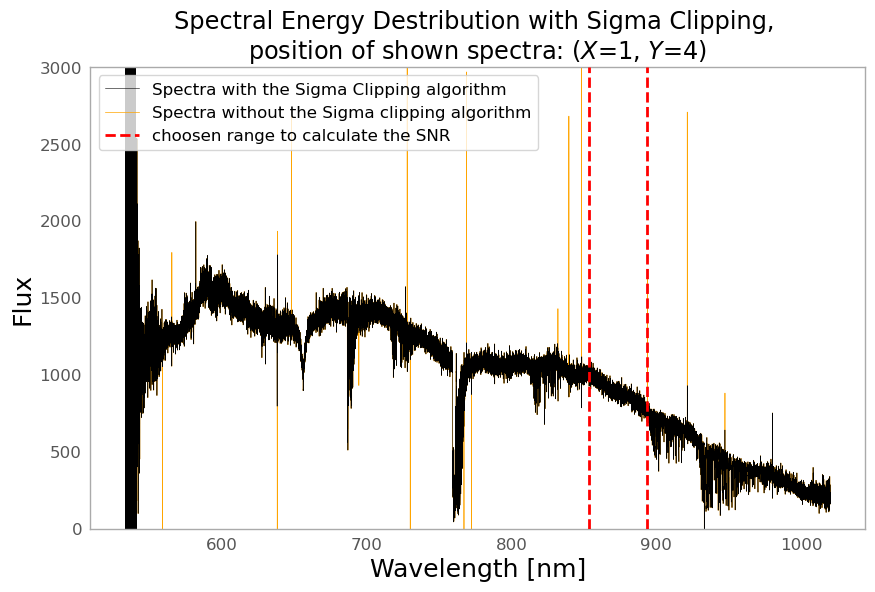

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 4 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

ylim = 3000

axes.set_title("Spectral Energy Destribution with Sigma Clipping, \nposition of shown spectra: ($X$=" + str(X) + ", $Y$=" + str(Y) + ")")
axes.plot(wave_NIR, cut_offset[:, Y, X], c="k", linewidth=.4, alpha=1, label="Spectra with the Sigma Clipping algorithm")
axes.plot(wave_NIR, spiky_data[:, Y, X], c="orange", linewidth=.5, alpha=1, label="Spectra without the Sigma clipping algorithm", zorder=-10)
axes.vlines(wave_NIR[18000], 0, ylim, color="red", linewidth=2, linestyle="--", zorder=11, label="choosen range to calculate the SNR")
axes.vlines(wave_NIR[16000], 0, ylim, color="red", linewidth=2, linestyle="--", zorder=11)
axes.set_ylabel("Flux", fontsize=18)
axes.set_xlabel("Wavelength [nm]", fontsize=18)

axes.set_ylim(-1, ylim)
#axes.set_xlim(295, 555)

axes.grid(False)


a = int(closest(320, wave_NIR))
b = int(closest(400, wave_NIR))
#axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="U filter")

a = int(closest(400, wave_NIR))
b = int(closest(500, wave_NIR))
#axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="B filter")
axes.legend(loc='upper left')

In [30]:
max_lambda = 18000
min_lambda = 16000

In [31]:
wave_NIR[8000] - wave_NIR[8100]

-1.9999999552965164

In [32]:
lambda_values = wave_NIR[min_lambda:max_lambda]
StoN_radius = np.zeros(len(radius))
signal_r = np.zeros(len(radius))
noise_r = np.zeros(len(radius))
radius_spaxel = np.zeros(len(radius))
spec_r = np.zeros((len(radius), len(lambda_values)))

def linear(x, m, c):
    return m*x + c

for r in range(1, len(radius)):
    flujo_sumado = np.zeros(len(lambda_values))
    pixel_count = 0
    for i in range(pix_x):
        for j in range(pix_y):
            ventana = cut_offset[min_lambda:max_lambda, j, i]
            if distance_matrix[j, i] < radius[r]:
                flujo_sumado = flujo_sumado + ventana
                pixel_count += 1
    radius_spaxel[r] = pixel_count
    signal_r[r] = np.sum(flujo_sumado) 

    popt, pcov = curve_fit(linear, lambda_values, flujo_sumado)
    m, c = popt
    noise_r[r] = np.std((flujo_sumado - linear(lambda_values, m, c)))
    spec_r[r] =  flujo_sumado
    StoN_radius[r] = signal_r[r] / noise_r[r]

In [33]:
lambda_values = wave_NIR[min_lambda:max_lambda]
StoN_radius_spiky = np.zeros(len(radius))
signal_r_spiky = np.zeros(len(radius))
noise_r_spiky = np.zeros(len(radius))
radius_spaxel = np.zeros(len(radius))
spec_r_spiky = np.zeros((len(radius), len(lambda_values)))

def linear(x, m, c):
    return m*x + c

for r in range(1, len(radius)):
    flujo_sumado = np.zeros(len(lambda_values))
    pixel_count = 0
    for i in range(pix_x):
        for j in range(pix_y):
            ventana = spiky_data[min_lambda:max_lambda, j, i]
            if distance_matrix[j, i] < radius[r]:
                flujo_sumado = flujo_sumado + ventana
                pixel_count += 1
    radius_spaxel[r] = pixel_count
    signal_r_spiky[r] = np.sum(flujo_sumado) 

    popt, pcov = curve_fit(linear, lambda_values, flujo_sumado)
    m, c = popt
    noise_r_spiky[r] = np.std((flujo_sumado - linear(lambda_values, m, c)))
    spec_r_spiky[r] =  flujo_sumado
    StoN_radius_spiky[r] = signal_r_spiky[r] / noise_r_spiky[r]

In [34]:
lambda_values = wave_NIR[min_lambda:max_lambda]
StoN_radius_ = np.zeros(len(radius))
signal_r_ = np.zeros(len(radius))
noise_r_ = np.zeros(len(radius))
radius_ = np.zeros(len(radius))
spec_r_ = np.zeros((len(radius), len(lambda_values)))

def linear(x, m, c):
    return m*x + c

for r in range(1, len(radius)):
    flujo_sumado = np.zeros(len(lambda_values))
    pixel_count = 0
    for i in range(pix_x):
        for j in range(pix_y):
            ventana = cut_offset_[min_lambda:max_lambda, j, i]
            if distance_matrix[j, i] < radius[r]:
                flujo_sumado = flujo_sumado + ventana
                pixel_count += 1
    radius_spaxel[r] = pixel_count
    signal_r_[r] = np.sum(flujo_sumado) 

    popt, pcov = curve_fit(linear, lambda_values, flujo_sumado)
    m, c = popt
    noise_r_[r] = np.std((flujo_sumado - linear(lambda_values, m, c)))
    spec_r_[r] =  flujo_sumado
    StoN_radius_[r] = signal_r_[r] / noise_r_[r]

In [35]:
lambda_values = wave_NIR[min_lambda:max_lambda]
StoN_radius_nir = np.zeros(len(radius))
signal_r_nir = np.zeros(len(radius))
noise_r_nir = np.zeros(len(radius))
radius_nir = np.zeros(len(radius))
spec_r_nir = np.zeros((len(radius), len(lambda_values)))

def linear(x, m, c):
    return m*x + c

for r in range(1, len(radius)):
    flujo_sumado = np.zeros(len(lambda_values))
    pixel_count = 0
    for i in range(pix_x):
        for j in range(pix_y):
            ventana = data_nir[min_lambda:max_lambda, j, i]
            if distance_matrix[j, i] < radius[r]:
                flujo_sumado = flujo_sumado + ventana
                pixel_count += 1
    radius_spaxel[r] = pixel_count
    signal_r_nir[r] = np.sum(flujo_sumado) 

    popt, pcov = curve_fit(linear, lambda_values, flujo_sumado)
    m, c = popt
    noise_r_nir[r] = np.std((flujo_sumado - linear(lambda_values, m, c)))
    spec_r_nir[r] =  flujo_sumado
    StoN_radius_nir[r] = signal_r_nir[r] / noise_r_nir[r]

IndexError: list index out of range

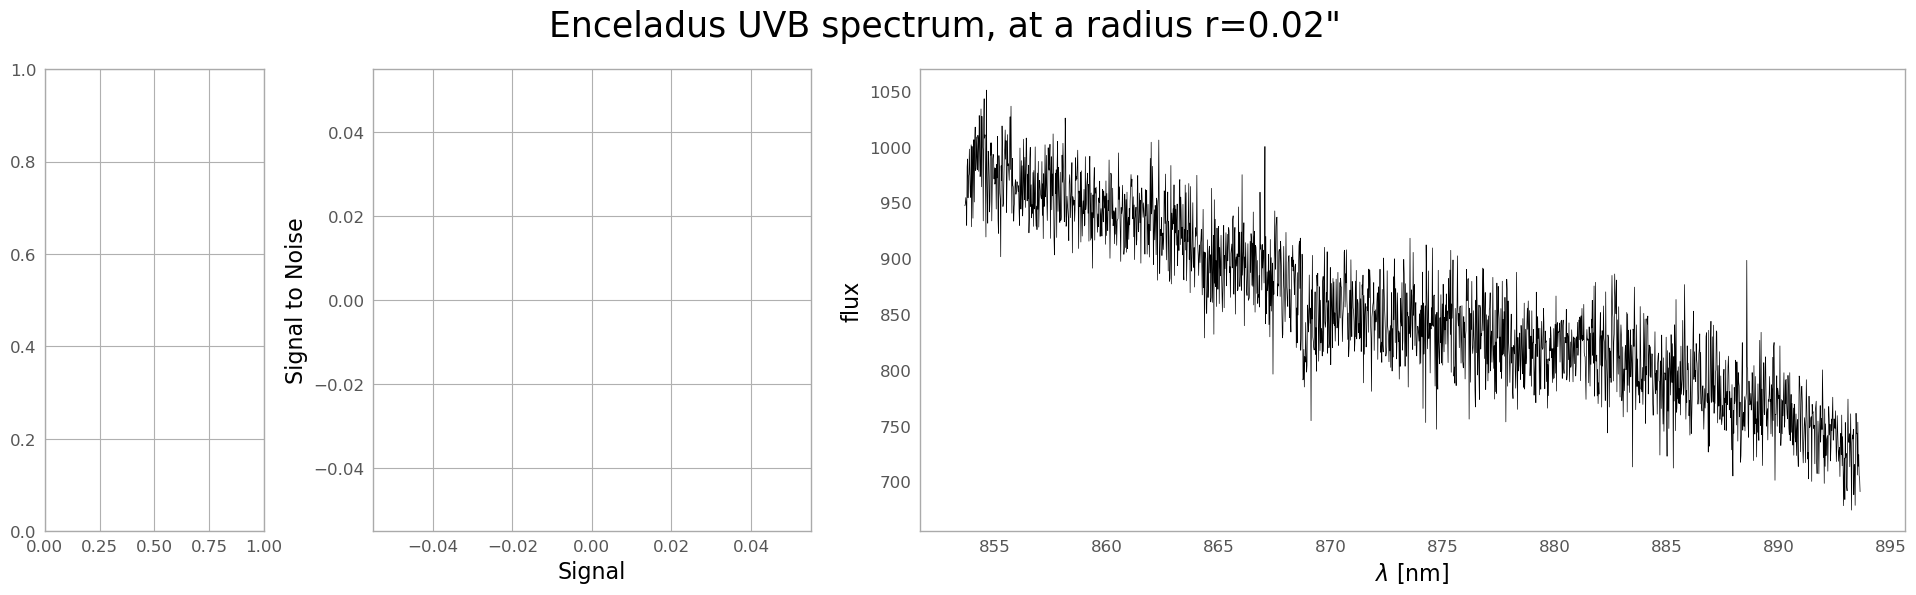

In [36]:
import matplotlib.animation as animation
import matplotlib as mpl

fig, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 4.5]}, figsize=(24, 6))
T = np.arange(1, 100)  # vector temporal
radius_spaxel = np.zeros(len(radius))


def n(t):
    axes[2].clear()
    fig.suptitle('Enceladus UVB spectrum, at a radius r=' + str(np.round(radius[t], 2)) + '"', fontsize=25)
    axes[2].plot(lambda_values, spec_r[t, :], c="k", linewidth=.5)
    #axes[0].set_ylim(-300, 300)
    axes[2].set_ylabel("flux", fontsize=16)
    axes[2].set_xlabel("$\lambda$ [nm]", fontsize=16)
    axes[2].grid(False)

    axes[1].plot(signal_r[1:t], StoN_radius[1:t], c="k")
    axes[1].set_ylabel("Signal to Noise", fontsize=16)
    axes[1].set_xlabel("Signal", fontsize=16)
    axes[1].set_ylim(np.min(StoN_radius)*0.9, np.max(StoN_radius[1:t])*1.1)
    axes[1].set_xlim(np.min(signal_r)*0.9, np.min(signal_r)*1.1)
    axes[1].grid(False)


    planet = np.zeros((pix_y, pix_x))
    for i in range(pix_x):
        for j in range(pix_y):
            if distance_matrix[j, i] <= radius[t]:
                planet[j, i] = 1
                radius_spaxel[t] = np.sum(planet)

    axes[0].imshow(planet, aspect=0.25641, origin="lower", cmap=mpl.colormaps["turbo"])
    axes[0].set_ylabel('y [pix] (4")', fontsize=16)
    axes[0].set_xlabel('x [pix] (1.8")', fontsize=16)
    axes[0].grid(False)


ani = animation.FuncAnimation(fig, n, T, interval= 10)
writergif = animation.PillowWriter(fps=15)
ani.save('..\Gifs\radius_SignalToNoiseUVB.gif', writer=writergif)
plt.show()

In [ ]:
radioPlaneta = radius[np.where(StoN_radius == np.max(StoN_radius))[0][0]]
indiceRadio = np.max([np.where(radius_spaxel == 9)[0]])

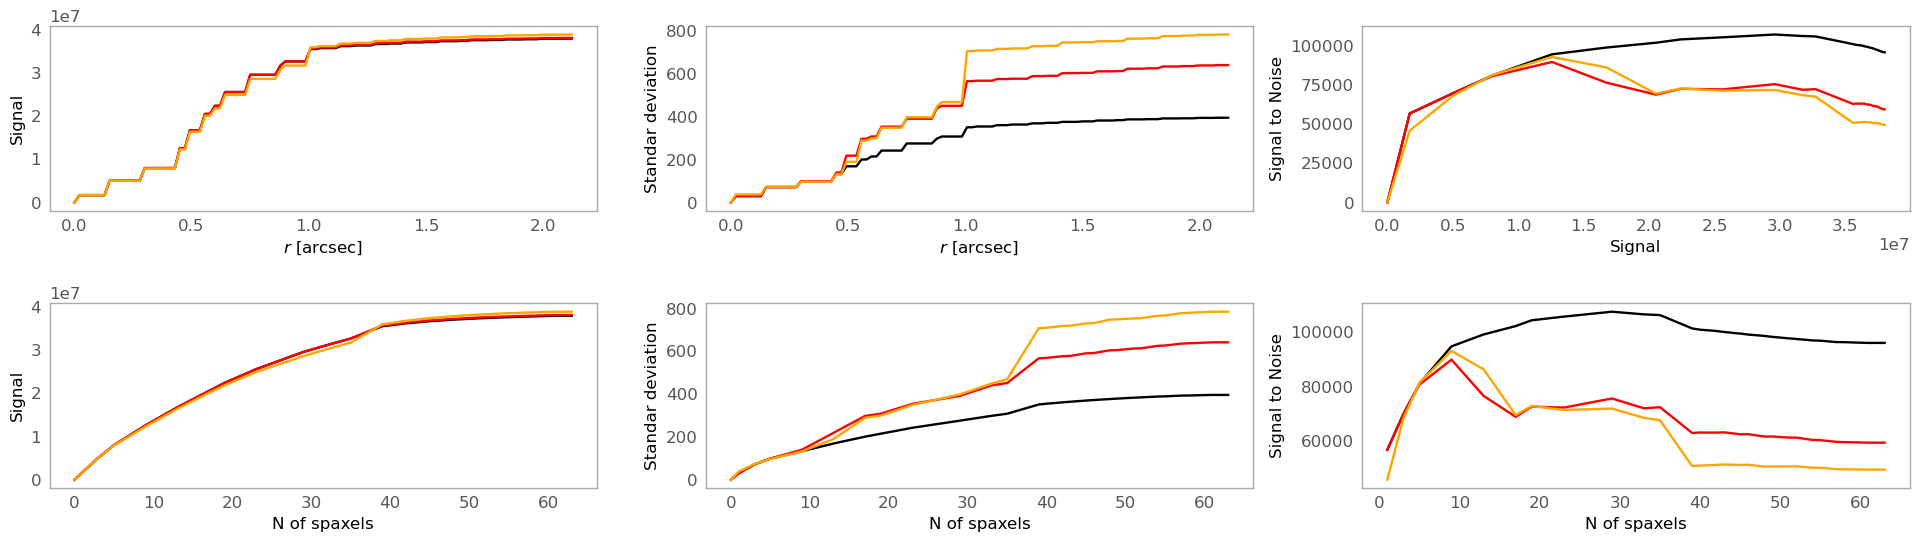

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(24, 6))

axes[0, 0].plot(radius, signal_r, c="k")
axes[0, 0].plot(radius, signal_r_spiky, c="red")
axes[0, 0].plot(radius, signal_r_, c="orange")
axes[0, 0].set_ylabel("Signal", fontsize=12)
axes[0, 0].set_xlabel("$r$ [arcsec]", fontsize=12)
axes[0, 0].grid(False)

axes[0, 1].plot(radius, noise_r, c="k")
axes[0, 1].plot(radius, noise_r_spiky, c="red")
axes[0, 1].plot(radius, noise_r_, c="orange")
axes[0, 1].set_ylabel("Standar deviation", fontsize=12)
axes[0, 1].set_xlabel("$r$ [arcsec]", fontsize=12)
axes[0, 1].grid(False)

axes[0, 2].plot(signal_r, StoN_radius, c="k")
axes[0, 2].plot(signal_r, StoN_radius_spiky, c="red")
axes[0, 2].plot(signal_r, StoN_radius_, c="orange")
axes[0, 2].set_ylabel("Signal to Noise", fontsize=12)
axes[0, 2].set_xlabel("Signal", fontsize=12)
axes[0, 2].grid(False)

axes[1, 0].plot(radius_spaxel, signal_r, c="k")
axes[1, 0].plot(radius_spaxel, signal_r_spiky, c="red")
axes[1, 0].plot(radius_spaxel, signal_r_, c="orange")
axes[1, 0].set_ylabel("Signal", fontsize=12)
axes[1, 0].set_xlabel("N of spaxels", fontsize=12)
axes[1, 0].grid(False)

axes[1, 1].plot(radius_spaxel, noise_r, c="k")
axes[1, 1].plot(radius_spaxel, noise_r_spiky, c="red")
axes[1, 1].plot(radius_spaxel, noise_r_, c="orange")
axes[1, 1].set_ylabel("Standar deviation", fontsize=12)
axes[1, 1].set_xlabel("N of spaxels", fontsize=12)
axes[1, 1].grid(False)

axes[1, 2].plot(radius_spaxel[1:], StoN_radius[1:], c="k")
axes[1, 2].plot(radius_spaxel[1:], StoN_radius_spiky[1:], c="red")
axes[1, 2].plot(radius_spaxel[1:], StoN_radius_[1:], c="orange")
axes[1, 2].set_ylabel("Signal to Noise", fontsize=12)
axes[1, 2].set_xlabel("N of spaxels", fontsize=12)
axes[1, 2].grid(False)

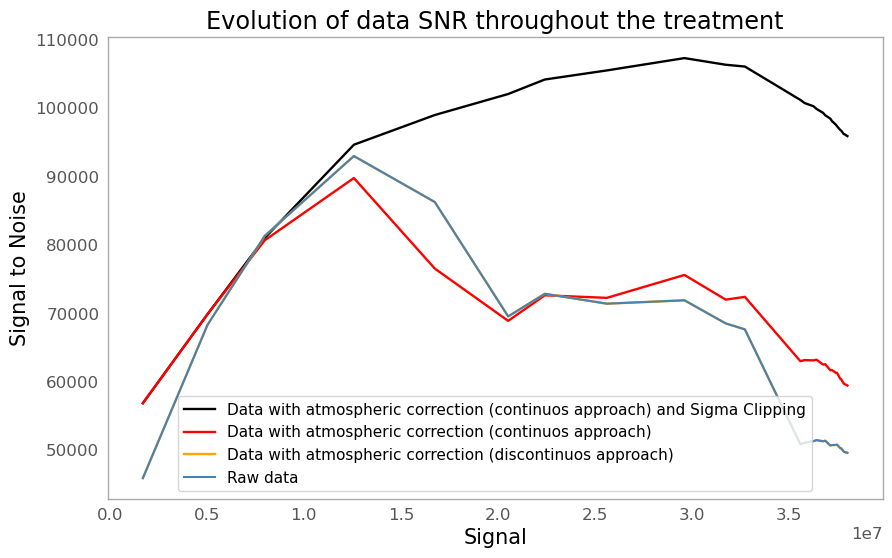

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.set_title("Evolution of data SNR throughout the treatment")
axes.plot(signal_r[1:], StoN_radius[1:], c="k", label="Data with atmospheric correction (continuos approach) and Sigma Clipping")
axes.plot(signal_r[1:], StoN_radius_spiky[1:], c="red", label="Data with atmospheric correction (continuos approach)")
axes.plot(signal_r[1:], StoN_radius_[1:], c="orange", label="Data with atmospheric correction (discontinuos approach)")
axes.plot(signal_r[1:], StoN_radius_nir[1:], c="steelblue", label="Raw data", linewidth=1.5)
#axes.plot(signal_r[indiceRadio], StoN_radius[indiceRadio], ".", color="purple", markersize=10)
axes.set_ylabel("Signal to Noise", fontsize=15)
axes.set_xlabel("Signal", fontsize=15)
plt.legend(fontsize=11)
#axes[2].set_xlim(0, 2.77)
axes.grid(False)

[18.06488788]


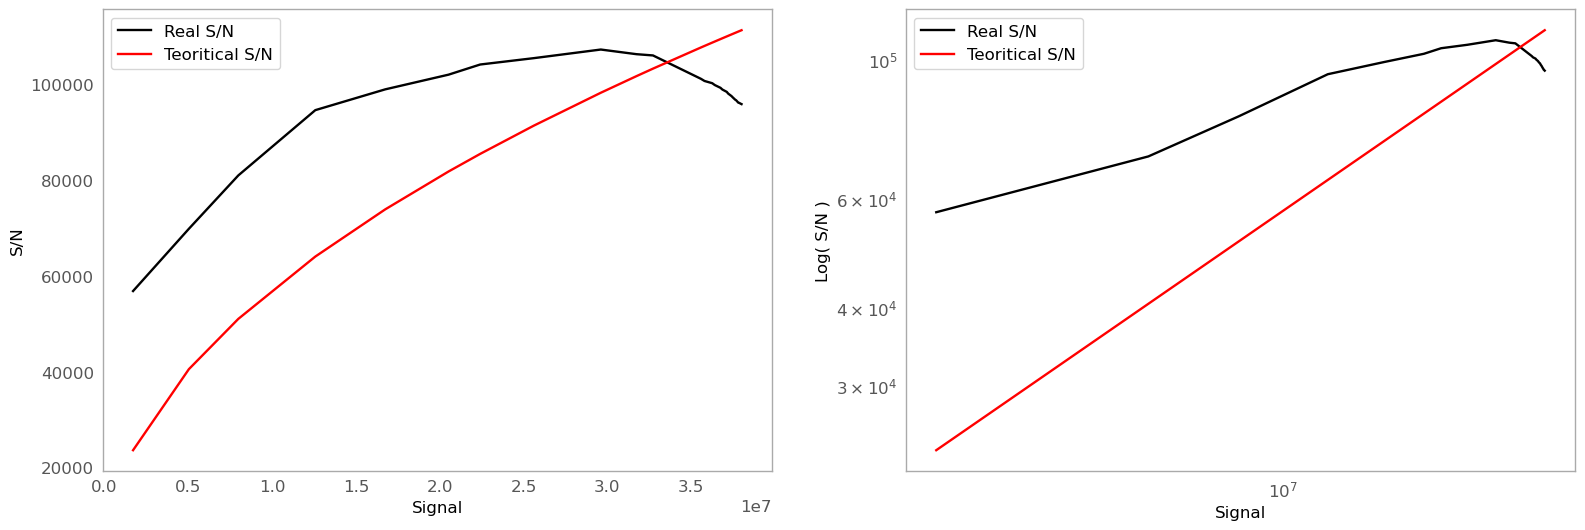

In [ ]:
def f(x, alpha):
    return alpha*np.sqrt(x)

# Fit a line to the spectrum
popt, pcov = curve_fit(f, signal_r[1:90], StoN_radius[1:90])
alpha = popt

print(alpha)

fig, axes = plt.subplots(1, 2, figsize=(19, 6))

axes[0].plot(signal_r[1:], StoN_radius[1:], c="k", label = "Real S/N")
axes[0].set_ylabel("S/N", fontsize=12)
axes[0].set_xlabel("Signal", fontsize=12)
axes[0].plot(signal_r[1:], f(signal_r[1:], alpha), c="red", label="Teoritical S/N")
#axes[0].scatter(signal_r[10], sqrt(signal_r[10], alpha), c="k", s=100, zorder=10, label="Best radius")
axes[0].legend()
axes[0].grid(False)


axes[1].plot(signal_r[1:], StoN_radius[1:], c="k", label = "Real S/N")
axes[1].set_ylabel("Log( S/N )", fontsize=12)
axes[1].set_xlabel("Signal", fontsize=12)
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].plot(signal_r[1:], f(signal_r[1:], alpha), c="red", label="Teoritical S/N")
#axes[1].scatter(radius_spaxel[35], sqrt(radius_spaxel[35], alpha), c="k", s=100, zorder=10, label="Best radius")
axes[1].legend()
axes[1].grid(False)

22.96181078916211
4369581.028449179


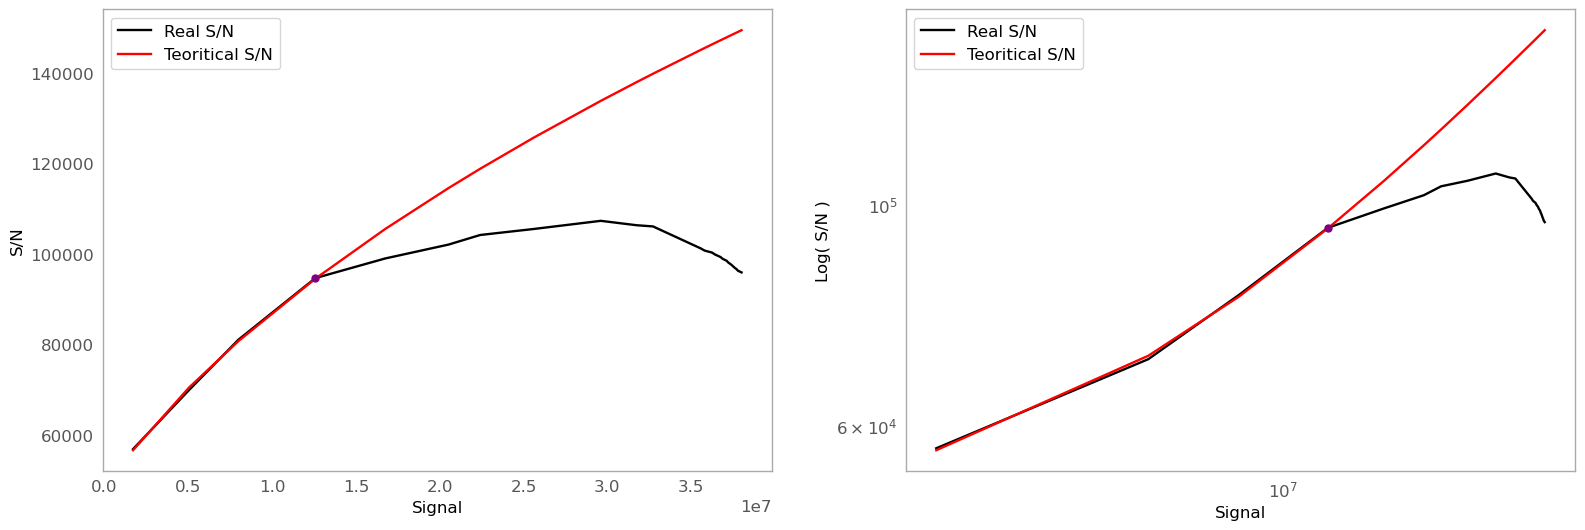

In [ ]:
def f(x, alpha, cte):
    return alpha*np.sqrt(x + cte) 

# Fit a line to the spectrum
popt, pcov = curve_fit(f, signal_r[1:indiceRadio], StoN_radius[1:indiceRadio])
alpha, cte = popt

print(alpha)
print(cte)

fig, axes = plt.subplots(1, 2, figsize=(19, 6))

axes[0].plot(signal_r[1:], StoN_radius[1:], c="k", label = "Real S/N")
axes[0].set_ylabel("S/N", fontsize=12)
axes[0].set_xlabel("Signal", fontsize=12)
axes[0].plot(signal_r[1:], f(signal_r[1:], alpha, cte), c="red", label="Teoritical S/N")
axes[0].plot(signal_r[indiceRadio], StoN_radius[indiceRadio],  ".", c="purple", markersize=10)
#axes[0].scatter(signal_r[10], sqrt(signal_r[10], alpha), c="k", s=100, zorder=10, label="Best radius")
axes[0].legend()
axes[0].grid(False)


axes[1].plot(signal_r[1:], StoN_radius[1:], c="k", label = "Real S/N")
axes[1].set_ylabel("Log( S/N )", fontsize=12)
axes[1].set_xlabel("Signal", fontsize=12)
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].plot(signal_r[1:], f(signal_r[1:], alpha, cte), c="red", label="Teoritical S/N")
axes[1].plot(signal_r[indiceRadio], StoN_radius[indiceRadio],  ".", c="purple", markersize=10)
#axes[1].scatter(radius_spaxel[35], sqrt(radius_spaxel[35], alpha), c="k", s=100, zorder=10, label="Best radius")
axes[1].legend()
axes[1].grid(False)

In [ ]:
for i in range(1, len(radius)):
    if np.abs(f(signal_r[i], alpha, cte) - StoN_radius[i]) > f(signal_r[i], alpha, cte)*0.01:
        indiceRadio = i - 1
        break

22.96181078916211
4369581.028449179


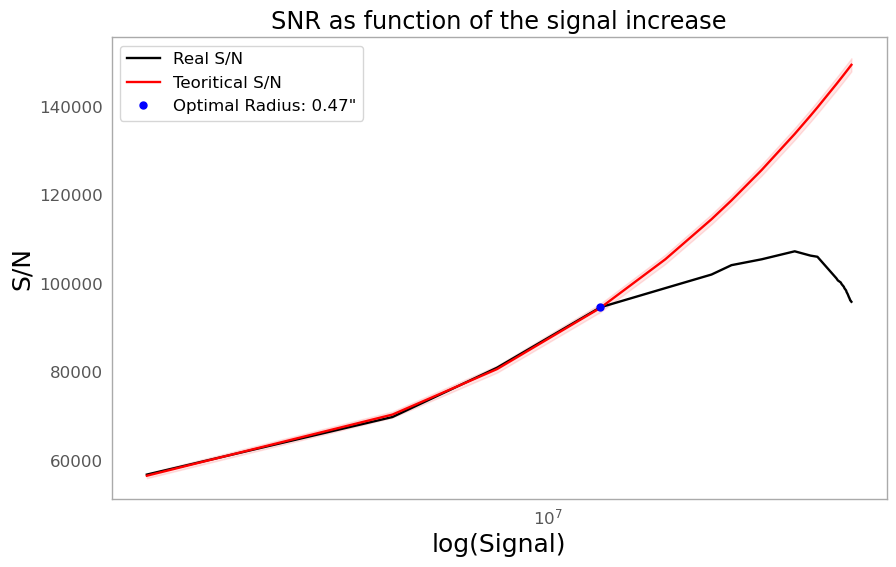

In [ ]:
print(alpha)
print(cte)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.set_title("SNR as function of the signal increase")
axes.plot(signal_r[1:], StoN_radius[1:], c="k", label = "Real S/N")
axes.set_ylabel("S/N", fontsize=18)
axes.set_xlabel("log(Signal)", fontsize=18)
axes.plot(signal_r[1:], f(signal_r[1:], alpha, cte), c="red", label="Teoritical S/N")
axes.fill_between(signal_r[1:], 0.99*f(signal_r[1:], alpha, cte), 1.01*f(signal_r[1:], alpha, cte), color="red", alpha=0.1)
axes.plot(signal_r[indiceRadio], StoN_radius[indiceRadio],  ".", c="blue", markersize=10, label="Optimal Radius: "+ str(np.round(radius[indiceRadio],2 ))+ '"')
axes.set_xscale("log")
#axes[0].scatter(signal_r[10], sqrt(signal_r[10], alpha), c="k", s=100, zorder=10, label="Best radius")
axes.legend()
axes.grid(False)

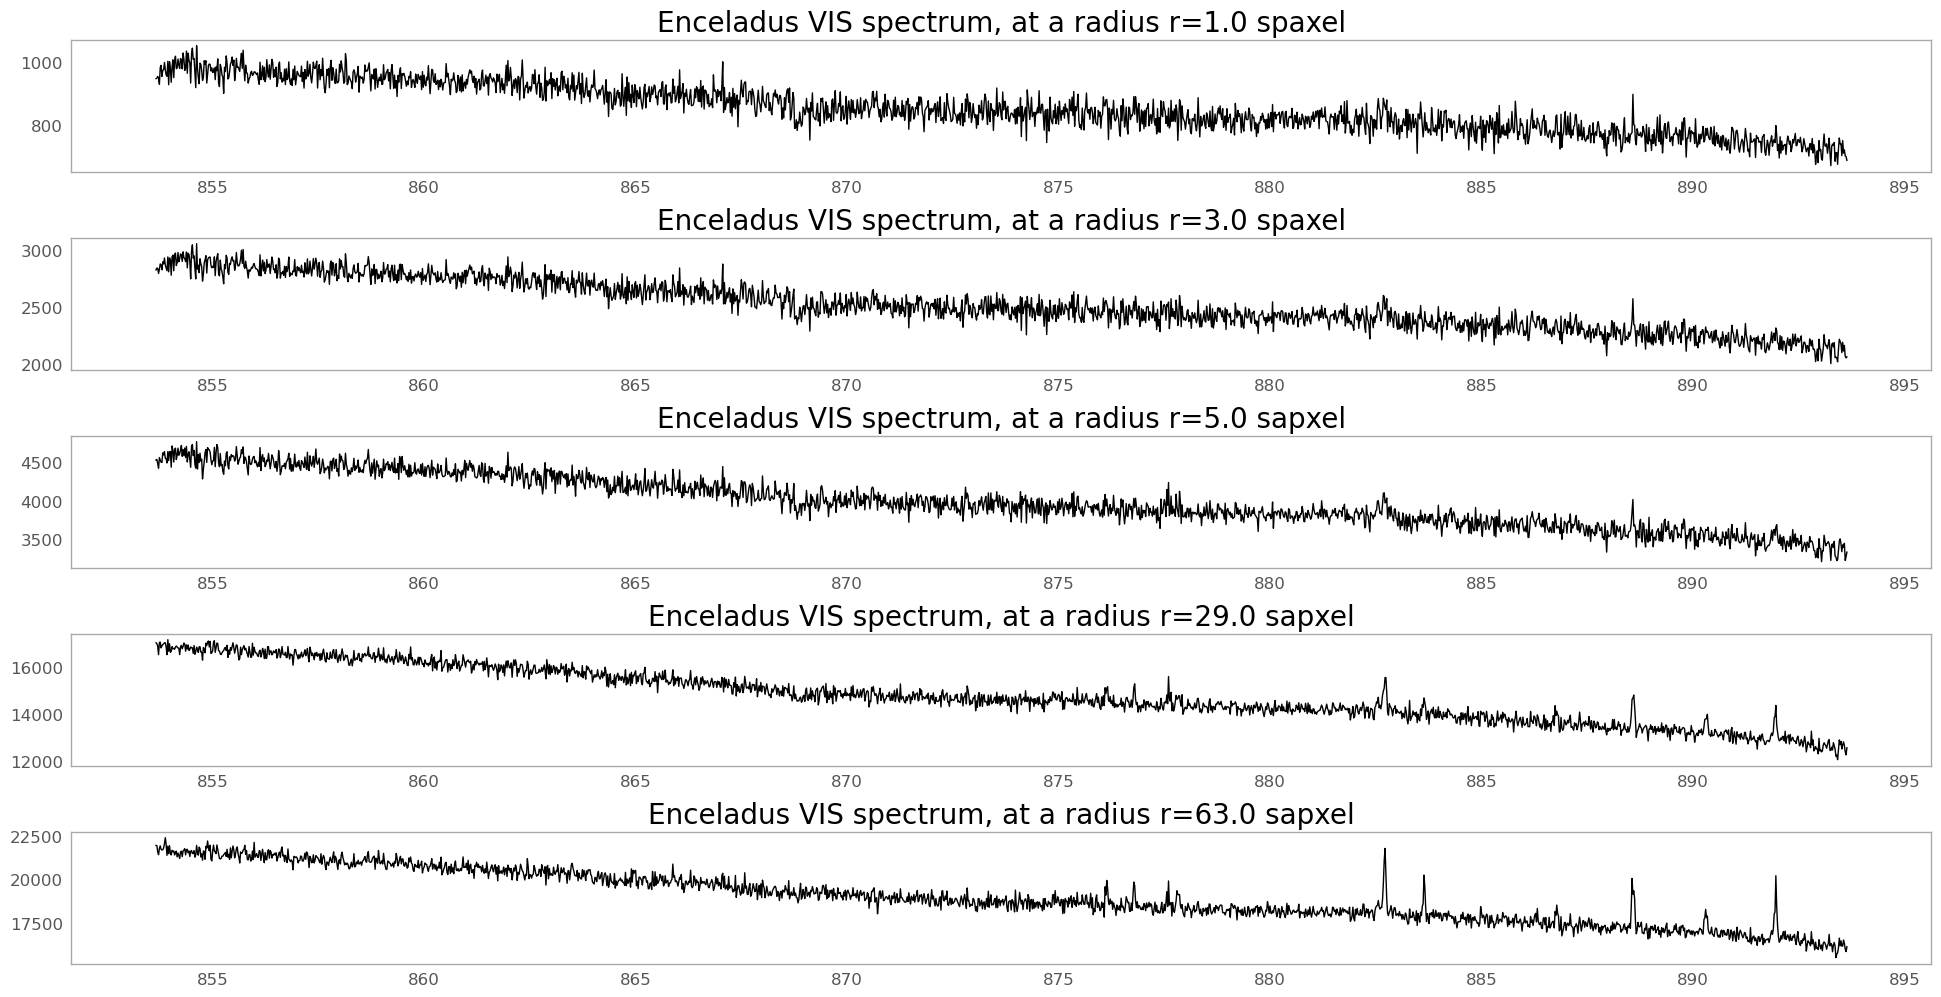

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(24, 12))

t=3
axes[0].set_title('Enceladus VIS spectrum, at a radius r=' + str(radius_spaxel[t]) + ' spaxel', fontsize=20)
axes[0].plot(lambda_values, spec_r[t,  :], c="k", linewidth=1)
axes[0].grid(False)

t=10
axes[1].set_title('Enceladus VIS spectrum, at a radius r=' + str(radius_spaxel[t]) + ' spaxel', fontsize=20)
axes[1].plot(lambda_values, spec_r[t,  :], c="k", linewidth=1)
axes[1].grid(False)

t=20
axes[2].set_title('Enceladus VIS spectrum, at a radius r=' + str(radius_spaxel[t]) + ' sapxel', fontsize=20)
axes[2].plot(lambda_values, spec_r[t,  :], c="k", linewidth=1)
axes[2].grid(False)

t=40
axes[3].set_title('Enceladus VIS spectrum, at a radius r=' + str(radius_spaxel[t]) + ' sapxel', fontsize=20)
axes[3].plot(lambda_values, spec_r[t,  :], c="k", linewidth=1)
axes[3].grid(False)

t=99
axes[4].set_title('Enceladus VIS spectrum, at a radius r=' + str(radius_spaxel[t]) + ' sapxel', fontsize=20)
axes[4].plot(lambda_values, spec_r[t,  :], c="k", linewidth=1)
axes[4].grid(False)

In [ ]:
print("radio del objeto:          " + str(radius[indiceRadio]))
print("radio del objeto:          " + str(radius_spaxel[indiceRadio]))
print("dimensiones del objeto:    " + "(y=" + str(int(largo_y-2*diferencia_centro)) +", x=" + str(int(pix_x)) + ")")
print("centro del objeto:         " + "(y=" + str(int(centro[0])) +", x=" + str(int(centro[1])) + ")")

radio del objeto:          0.4716288174708469
radio del objeto:          9.0
dimensiones del objeto:    (y=21, x=3)
centro del objeto:         (y=6, x=1)


In [ ]:
flujo_final= np.zeros(len(wave_NIR))
for i in range(pix_x):
    for j in range(pix_y):
        ventana = cut_offset[:, j, i]
        if distance_matrix[j, i] < radius[indiceRadio]:
            flujo_final = flujo_final + ventana


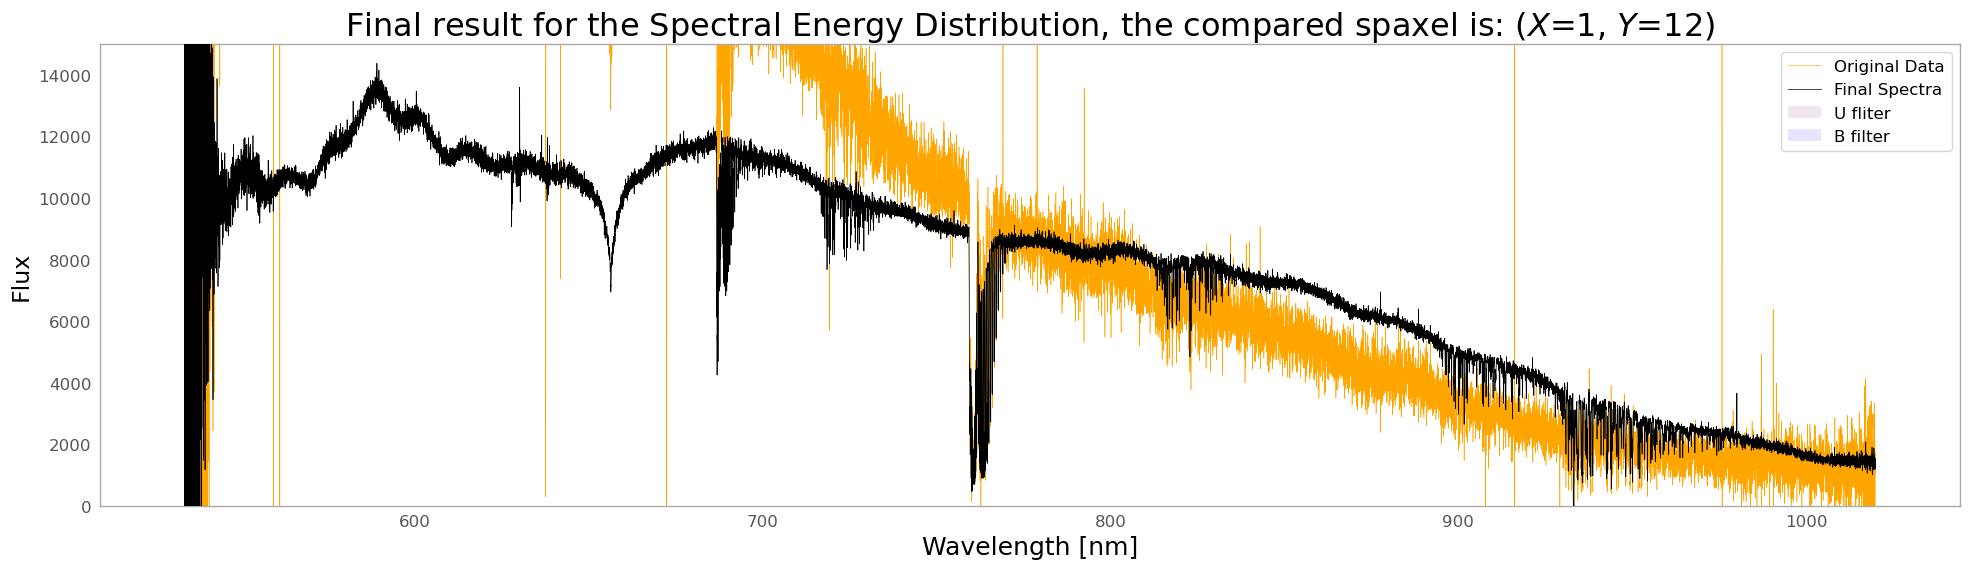

In [ ]:
X = 1 # Posición horizontal del pixel que se le busca el espectro, va de 0 a 2
Y = 12 # Posición vertical del pixel que se le busca el espectro, va de 0 a 25

ylim = 15000

# !!! Porque NIR tiene solo 20 pixeles? !!!

fig, axes = plt.subplots(1, 1, figsize=(24, 6))

compara = data_nir[:, Y, X]
normalizacion = np.percentile(flujo_final, 50)
normalizacion2 = np.percentile(compara, 50)

axes.set_title("Final result for the Spectral Energy Distribution, the compared spaxel is: ($X$=" + str(X) + ", $Y$=" + str(Y) + ")", fontsize=23)
axes.plot(wave_NIR, compara * normalizacion/normalizacion2, c="orange", linewidth=.4, label="Original Data")
axes.plot(wave_NIR, flujo_final, c="k", linewidth=.5, label="Final Spectra", zorder=10)
axes.set_ylabel("Flux", fontsize=17)
axes.set_xlabel("Wavelength [nm]", fontsize=18)
axes.set_ylim(-1, ylim)


axes.grid(False)


a = int(closest(320, wave_NIR))
b = int(closest(400, wave_NIR))
axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='purple', alpha=0.1, label="U fliter")

a = int(closest(400, wave_NIR))
b = int(closest(500, wave_NIR))
axes.fill_between(wave_NIR[a:b], 0, ylim, facecolor='blue', alpha=0.1, label="B filter")

axes.legend()
medianas = np.zeros((largo_y-2*diferencia_centro, pix_x))


In [ ]:
hdul = fits.open("..\..\Enceladus\OffsetU\XSHOO.2019-09-26T01_56_56.495_tpl\MOV_Enceladus_SCI_IFU_MERGE3D_DATA_OBJ_UVB.fits")
hdr = hdul[0].header
hdr["SH SPAXELS R"] = radius_spaxel[indiceRadio]
hdr["SH ANGULAR R"] = radius[indiceRadio]
hdr["SH SIGMA CLIPPING"] = A
hdr["SH DATA DIMENSIONS Y"] = largo_y-2*diferencia_centro
hdr["SH DATA DIMENSIONS X"] = pix_x
hdr["SH OBJECT CENTER Y"] = centro[0]
hdr["SH OBJECT CENTER X"] = centro[1]
hdr["COMMENT"] = "This is the Disk Integrated data of body observed. All the comments starting with SH caracters are the ones provided by Sebastian Hermosilla. In case of any question write to s.hermosilla@ing.uchile.cl"
empty_primary = fits.PrimaryHDU(flujo_final, header=hdr)

hdul = fits.HDUList([empty_primary])
hdul.writeto('..\..\Final_data_Enceladus\Enceladus_DiskIntegrated_UVB_O1.fits', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\Enceladus\\OffsetU\\XSHOO.2019-09-26T01_56_56.495_tpl\\MOV_Enceladus_SCI_IFU_MERGE3D_DATA_OBJ_UVB.fits'